# Понятие переобучения

## Исходные данные

Для этого занятия нам понадобится файл `non_linear.csv` который хранится в [директории курса на Google Drive](https://drive.google.com/file/d/1prHJVpHn0N5y1BqLQQ2Hpx5OP8uKIXjT/view?usp=sharing)

Скопируйте файл к себе в родительскую директорию **hse_nlp_2021**

In [1]:
import logging
import os
import sys
import shutil

import numpy as np
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'ml_course_data')
  sys.path.append(os.path.join(ROOT_DIR, 'MyDrive', 'src'))
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

print(os.listdir(root_data_dir))

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)))

Mounted at /content/drive
Google drive connected
['nyt-ingredients-snapshot-2015.csv', 'insurance (1).csv', 'non_linear.csv', 'client_segmentation.csv', 'eigen.pkl', 'clustering.pkl', 'boosting_toy_dataset.csv', 'politic_meme.jpg', 'gray_goose.jpg', 'test_dataset.pkl', 'memes', 'optimal_push_time', 'sklearn_data', 'my_little_recsys', 'corpora', 'logs', 'nltk_data', 'recsys_data', 'MNIST', 'hymenoptera_data', 'pet_projects', 'ocr_dataset_sample.csv', 'geo_points.csv.gzip', 'scored_corpus.csv', 'labeled_data_corpus.csv', 'memes_stat_dataset.zip', 'als_model.pkl', 'raw_data.zip', 'json_views.tar.gz', 'test_data.csv', 'sales_timeseries_dataset.csv.gz', 'brand_tweets_valid.csv', 'brand_tweets.csv', 'Health_and_Personal_Care.jsonl.gz', 'models', 'final_dataset.zip', 'ocr_dataset.zip', 'bidmachine_logs.zip', 'meta_Health_and_Personal_Care.jsonl.gz', 'messages.db', 'user_item_views.zip', 'content_catalog.zip', 'ground_truth_dataset.pkl', 'insurance.csv']
Содержимое директории /content/drive/My

# I Переобучение

## Как детектировать переобучение

Переобучение - это явление, когда модель "слишком сильно" подгоняется под обучающую выборку и плохо справляется с новыми данными - проведём эксперимент и увидим на примере линейной регрессии, как переобучаются модели

Начнем с исходных данных - их мы уже исследовали на прошлом семинаре

In [2]:
import os

import numpy as np
import pandas as pd

raw_data_file = os.path.join(root_data_dir, 'non_linear.csv')
data = pd.read_csv(raw_data_file, sep=',')

data.head()

,x_train,y_train
0,0.138368,0.838812
1,0.157237,0.889313
2,0.188684,1.430040
3,0.685553,1.717309
4,0.874237,2.032588


Визуализируем с помощью scatter

/tmp/ipython-input-3390839111.py:4: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8)


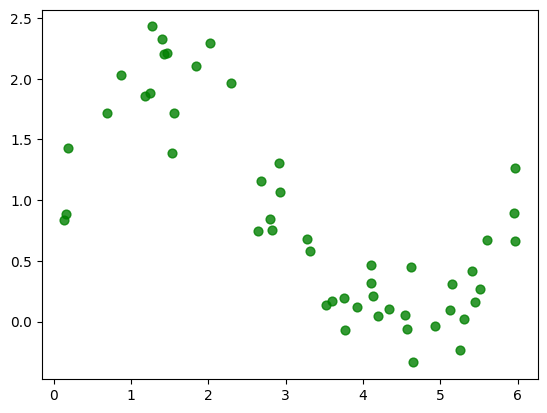

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# основной график
plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8)
plt.show()

Цель - научиться определять переобучение.

Тренироваться будем на полиномиальной регрессии. То есть регрессия-то будет линейная, но нужно будет сгенерить для каждого x признаки $x^2,\cdots, x^n$ и добавить в матрицу объекты-признаки $X$ несколько столбцов - степени фичей (например, в случае обучения регрессии на единственной фиче модуль приобретёт вид $y = w_0 + w_1x +w_2x^2 + \ldots + w_nx^n$).

Мы получаем более сложную модель - графики можно посмотреть на [Вики](https://ru.wikipedia.org/wiki/%D0%A6%D0%B5%D0%BB%D0%B0%D1%8F_%D1%80%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F)

То есть пространство функций у нас линейное, увеличивается количество только коэффициентов $w$

$$
\forall x_i: h(x) =  \sum_{j=1}^{n}w_jx_i^j
$$

Матрица, состоящая из степеней $x$ называется [матрицей Вандермондта](https://en.wikipedia.org/wiki/Vandermonde_matrix), реализация этой матрицы есть в `numpy`.

In [4]:
def generate_powers(x, N):
  return np.vander(x, N=N, increasing=True)[:,1:]

generate_powers(data.head(3).x_train.values, N=5)

array([[0.13836845, 0.01914583, 0.00264918, 0.00036656],
       [0.15723687, 0.02472343, 0.00388744, 0.00061125],
       [0.18868424, 0.03560174, 0.00671749, 0.00126748]])

In [5]:
0.138368**2

0.019145703424

Обучаем модель на валидации, проверяем на контроле для степени полинома `degree=8` (думаю, степень полинома можно назвать гиперпараметром). Для разбиения мы воспользуемся функцией [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

* $X$ и $y$ - массивы, которые хотим расщепить на валидацию и контроль
* *test_size* принимает значения от нуля до единицы и означает долю объектов, которые нужно отложить на валидацию (обычно выбирают значения между $0.15$ и $0.35$)
* *random_state* - любое целое число, если задано то разбиение не будет меняться в разных запусках программы (нужно для воспроизводимости). Мы используем константу `RANDOM_SEED`

Обучать будем линейную регрессию из класса [sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Вообще-то Ridge оптимизирует немного другой функционал, не совсем как в линейной регрерсии:

$$
\|Y - Xw\|^2_2 + \alpha \cdot \|w\|^2_2
$$

Поэтому будем обучать при $\alpha = 0$ чтобы получилась обычная линейная регрессия

Норма весов рассчитывается

$$
\|w\|^2_2 = w_0^2+w_1^2 + \ldots+w_n^2
$$

Для вычисления такой нормы можно использовать [функцию norm из numpy](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.norm.html)

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso  # импортируем новые для на модели
from sklearn.model_selection import train_test_split

degree = 8

# извлекаем признаки
X = generate_powers(data.x_train.values, N=degree)
y = data.y_train.values

# разделяем на обучающую и валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# обучаем модель
model = Ridge(alpha=0).fit(X_train, y_train)

# получаем предсказания
y_pred = model.predict(X_valid)
y_pred_train = model.predict(X_train)

print("Качество на обучении: %.3f" % mean_squared_error(y_train, y_pred_train))
print("Качество на валидации: %.3f" % mean_squared_error(y_valid, y_pred))

Качество на обучении: 0.072
Качество на валидации: 0.040


In [7]:
X.shape

(50, 7)

Теперь обучим полиномиальную регрессию для степени `degree = 12` c параметром регуляризации `alpha=0`

In [8]:
degree = 12
X = generate_powers(data.x_train.values, N=degree)
y = data.y_train.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
model = Ridge(alpha=0).fit(X_train, y_train)

y_pred = model.predict(X_valid)
y_pred_train = model.predict(X_train)

print("Качество на обучении: %.3f" % mean_squared_error(y_train, y_pred_train))
print("Качество на валидации: %.3f" % mean_squared_error(y_valid, y_pred))

Качество на обучении: 0.064
Качество на валидации: 0.050


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46336e-24): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [9]:
X.shape

(50, 11)

Как изменилась ошибка на обучении? Было $0.072$, стало $0.064$, т.е. *ошибка на обучении падает*.

Как изменилась ошибка на валидации? Было $0.04$, стало $0.05$, т.е. *ошибка на валидации растёт*.

Это и есть признак переобучения (выспоминаем графики) - ошибка на валидации растёт, а на обучении падает, степень полинома $n=12$ хуже, чем степень полинома $n=8$, модель переобучилась.

#### Самостоятельная работа

У класса *Ridge* в конструкторе есть параметр регуляризации - обучите регрессию при $\alpha=0.4$ для степени полинома 12

Как изменилась ошибка на обучении? Как изменилась ошибка на валидации? Удалось ли победить переобучение?

In [ ]:
from sklearn.linear_model import Ridge
from numpy.linalg import norm


degree = 12
alpha_control = 0.01
alpha_test = 0.4

model_ridge = Ridge(alpha=alpha_control)
model_linear = Ridge(alpha=alpha_test)

# задаём степень полинома
degree = 10

X = generate_powers(data['x_train'], degree)
y = data['y_train']
# обучаем линейную регрессию с  регуляризацией
model_ridge.fit(X, y)
model_linear.fit(X, y)

x_linspace = np.linspace(data['x_train'].min(), data['x_train'].max(), num=100)

y_linspace_linear = model_linear.predict(generate_powers(data['x_train'].values, degree))
y_linspace_ridge = model_ridge.predict(generate_powers(data['x_train'].values, degree))

plt.plot(x_linspace, y_linspace_linear)
plt.plot(x_linspace, y_linspace_ridge)

# -- ВАШ КОД ТУТ ---

print("Норма вектора весов Ridge \t||w|| = %.2f" % (norm(model_ridge.coef_)))
print("Норма вектора весов Linear \t||w|| = %.2f" % (norm(model_linear.coef_)))

# ------------------


plt.show()

Готово, модели обучены! мы видим тревожное сообщение **LinAlgWarning: Ill-conditioned matrix (rcond=2.23568e-22): result may not be accurate.** - тут ничего страшного, побороть это сообщение нам поможет знакомство с методом градиентного спуска

Мы видим, что регуляризованная модель более "гладкая", а вот у модели без регуляризации есть перегибы - она выглядит переобученной. Давайте проверим норму коэффициентов регрессии.

In [ ]:
print("Норма вектора весов Ridge \t||w|| = %.2f" % (norm(model_ridge.coef_)))
print("Норма вектора весов Linear \t||w|| = %.2f" % (norm(model_linear.coef_)))

Как видно, два разных (по норме) набора коэффициентов мы получили при двух разных значениях $\alpha$. Как же выбрать правильное значение коэффициента регуляризации? На помощь приходит процедура, которая называется отложенный контроль, как делали в первом уроке.

Реализуем эту процедуру на языке python. Для у нас есть готовая функция `sklearn.model_selection.train_test_split` :

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

Из 50 точек 40 попало в *train set* и 10 в *validation set* - давайте реализуем остальные шаги алгоритма

In [ ]:
alphas = [0.1, 0.15, 0.35, 0.5, 0.8]

best_alpha = alphas[0]
best_rmse = np.infty

for alpha in alphas:
    model_ridge = Ridge(alpha=alpha)
    # обучаем линейную регрессию с  регуляризацией
    model_ridge.fit(X_train, y_train)
    y_pred = model_ridge.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    if error < best_rmse:
        best_rmse = error
        best_alpha = alpha
    print("alpha =%.2f Ошибка %.5f" % (alpha, error))
print('\n-------\nЛучшая модель aplpha=%.2f с ошибкой RMSE=%.5f\n-------' % (best_alpha, best_rmse))

Переобучение - это плохо. Мы начинаем слишком сильно подгоняться под обучающую выборку и плохо "готовы" к новым данным. Детектировать можно с помощью валидационной выборки. Победить переобучение можно с помощью регуляризации в библиотечном классе Ridge

### Самостоятельная работа: Lasso vs Ridge

В стандартной библиотеке есть ещё интересный класс [sklearn.linear_model.Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

$$
\|Y - Xw\|^2_2 + \alpha \cdot \|w\|_1
$$

Норма весов рассчитывается по формуле

$$
\|w\|_1 = |w_0|+|w_1| + \ldots+|w_n|
$$

Для вычисления этой метрики используем [функцию norm из numpy](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.norm.html)

На данных из файла `data/non_linear.csv`
* сгенерируйте данные для степени `degree = 8`
* обучите модель `sklearn.linear_model.Lasso` и модель `sklearn.linear_model.Ridge` на полученных данных
* используйте коэффициент регуляризации $\alpha=0.8$ для обеих моделей
* постройте два столбчатых графика, на которых отобразите величину коэффициентов в для Ridge регрессии и Lasso регрессии виде столбиков

In [11]:
# -- ВАШ КОД ТУТ ---



# -------------------

Мы использовали реализацию Ridge регрессию из библиотеки sklearn. Для того, чтобы  прокачать навыки программирования и освежить в памяти, как перемножать матрицы в numpy, напишите код для вычисления коэффициентов полиномиальной регрессии (для степени *degree=8*) с регуляризацией по формуле
$$
\overline{w} = \left(X^TX + \lambda E\right)^{-1}X^T\overline{y}
$$

Сравните расхождение `model.intercept_ + model.coef_` с вашими коэффициентами

Не забудьте добавить столбец из единиц к маатрице фичей!

In [12]:
# -- ВАШ КОД ТУТ ---



# -------------------

# Переобучение на валидационной выборке

Посмотрим в динамике

N=%d	 valid err %.3f	 train err %.3f	||w|| = %.2f 3 0.24497135044487534 0.3137569726759203 0.46569133707581395


/tmp/ipython-input-1040147691.py:38: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(X_valid[:,0][order_test], y_valid[order_test], 40, 'r', 'o', alpha=0.8)


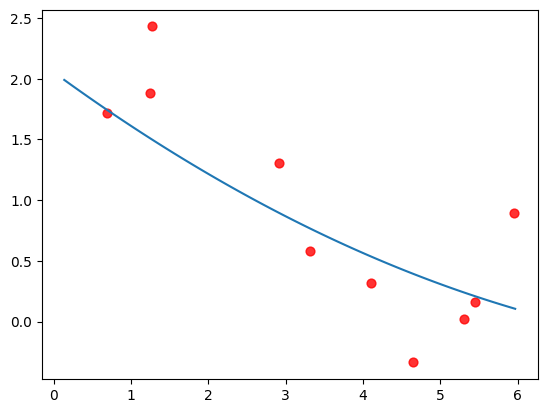

N=%d	 valid err %.3f	 train err %.3f	||w|| = %.2f 5 0.0628228730154251 0.06939048405548882 3.2338604393299772


/tmp/ipython-input-1040147691.py:38: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(X_valid[:,0][order_test], y_valid[order_test], 40, 'r', 'o', alpha=0.8)


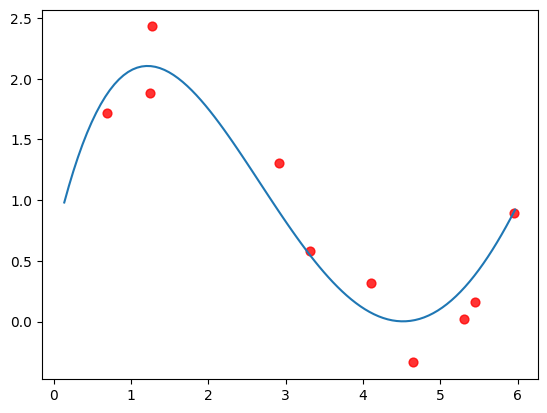

N=%d	 valid err %.3f	 train err %.3f	||w|| = %.2f 7 0.06673475022764103 0.06575195366001794 3.5374366557475114


/tmp/ipython-input-1040147691.py:38: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(X_valid[:,0][order_test], y_valid[order_test], 40, 'r', 'o', alpha=0.8)


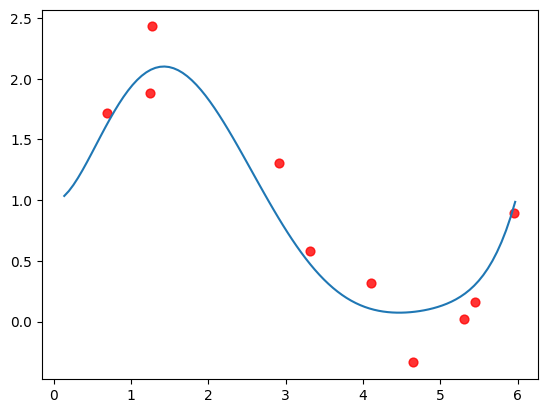

N=%d	 valid err %.3f	 train err %.3f	||w|| = %.2f 10 0.12328619090606993 0.051974988254216606 93.44022629349571


/tmp/ipython-input-1040147691.py:38: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(X_valid[:,0][order_test], y_valid[order_test], 40, 'r', 'o', alpha=0.8)


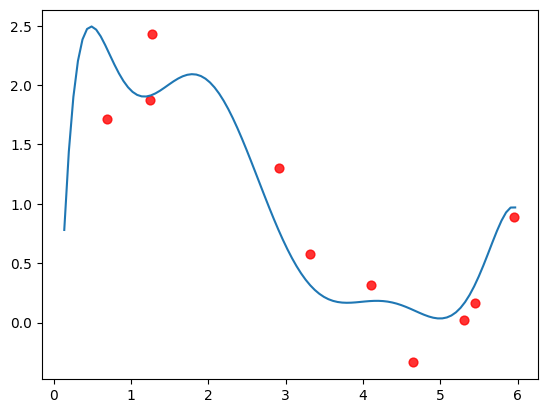

In [15]:
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def fit_regression(x_train, x_valid, y_train, y_valid):
    model = LinearRegression().fit(x_train, y_train)
    # ошибки на обучении и валидации
    y_pred = model.predict(x_valid)
    y_pred_train = model.predict(x_train)
    # для графиков
    error_valid = mean_squared_error(y_valid, y_pred)
    error_train = mean_squared_error(y_train, y_pred_train)
    w_norm = norm(model.coef_)

    return error_valid, error_train, w_norm, model

def train_polynomial(input_degrees, data):
    """Генерим данные, тренируем модель
    дополнительно рисуем график
    """
    x_linspace = np.linspace(data['x_train'].min(), data['x_train'].max(), num=100)
    y = data.y_train.values

    degrees, valid_errors, train_errors, w_norm = [], [], [], []
    for degree in input_degrees:
        # генерим фичи
        X = generate_powers(data.x_train.values, N=degree)
        # обучение и контроль зависят от степени полинома, т.к. меняется размерность
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)
        order_test = np.argsort(X_valid[:,0])
        # ошибка на тренировочном сете
        error_valid, error_train, coef_norm, model = fit_regression(X_train, X_valid, y_train, y_valid)
        print(
            "N=%d\t valid err %.3f\t train err %.3f\t||w|| = %.2f",
            degree, error_valid, error_train, norm(model.coef_)
        )
        plt.scatter(X_valid[:,0][order_test], y_valid[order_test], 40, 'r', 'o', alpha=0.8)
        # визуализируем решение
        y_linspace = model.predict(generate_powers(x_linspace, N=degree))
        plt.plot(x_linspace, y_linspace)
        plt.show()
        valid_errors.append(error_valid); train_errors.append(error_train); w_norm.append(coef_norm)
    return valid_errors, train_errors, w_norm

DEGREES = (3, 5, 7, 10)
valid_errors, train_errors, w_norm = train_polynomial(
    input_degrees=DEGREES, data=data
)

В этом абстрактном эксперименте: видны следующие закономерности

* степень полинома растёт $\rightarrow$ ошибка на тренировочных данных падает
* степень полинома растёт $\rightarrow$ ошибка на валидации растёт
* степень полинома растёт $\rightarrow$ сумма квадратов коэффициентов регрессии растёт

Т.е. можно детектировать переобучение, если проверять такую прокси-метрику как "норма весов регрессии"
* по оси $oX$ - степень полинома
* по оси $oY$ - ошибка на валидации и ошибка на обучении

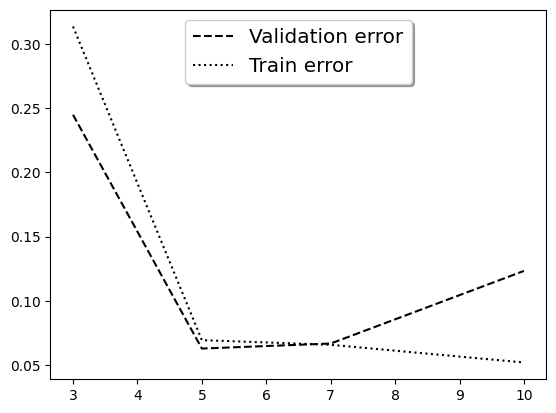

In [16]:
from matplotlib import pyplot
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(DEGREES, valid_errors, 'k--', label='Validation error')
ax.plot(DEGREES, train_errors, 'k:', label='Train error')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')


plt.show()

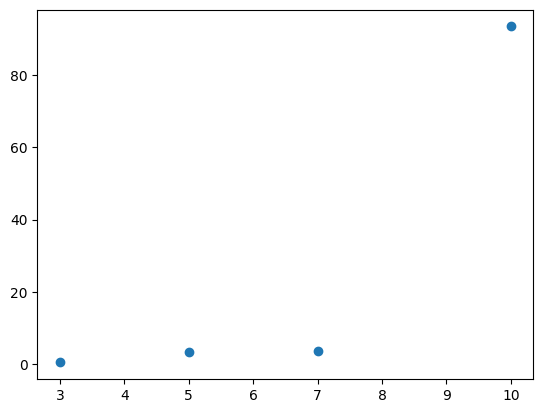

In [17]:
plt.scatter(DEGREES, w_norm)
plt.show()

Самостоятельное задание: подберите наилучший alpha с помощью [cross_val_score](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics)

In [18]:
# -- ВАШ КОД ТУТ ---



# ------------------

На графике можно заметить, как с ростом степень полинома ошибка на валидации начинает расти, а на обучении - наоборот, падать. Одновременно с ухудшением качества модели на валидации можно заметить, как растёт норма вектора коэффициентов $w$ -  от значения $2.19$ до значения $120.14$, то есть большие по модулю величины коэффициентов свидетельствуют о том, что модель переобучается.

При каком значении степени полинома модель будет получается сбалансированной и не "оверфиттится"? Эта точка - там, где две линии ошибок пересекаются, она соответствует степени полинома *degree=5*: модель достаточно хороша на обучении и не слишком плоха на валидации.

Что такое регуляризация и как она спасает от переобучения? мы получаем предсказания модели, используя коэффициенты регрессии, в виде

$$
\hat{y} = w_0x_0 + \ldots w_nx_n
$$

То есть величина коэффициентов $w$ по модулю сильно влияет на предсказания - чем больше коэффициенты линейной регрессии $w=[w_1,\ldots,w_n]$, тем больше таргет $y$ при одинаковом значении $x$, зависимость линейная.

Вспомним, что аналитическая формула для нахождения коэффициентов регрессии выглядит вот так
$$
\overline{w} = \left(X^TX\right)^{-1}X^TY
$$

Такое решение получается, когда мы минимизируем функцию ошибок $L$, где $N$ - число обучающих примеров:

$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2
$$

В эксперименте с полиномиальной регрессией мы выяснили простое правило - чем больше квадраты коэффициентов регрессии, тем хуже качество. Как же нам заставить модель делать коэффициенты поменьше, чтобы качество не страдало?

Самое простое решение, которое приходит на ум - каким-то образом "наказывать" нашу модель за слишком большие значения коэффициентов линейной регрессии $w$. Давайте добавим в функцию качества модели $L(y, w)$ дополнительное слагаемое, которое содержит квадрат нормы вектора весов $\|w\|^2$:

$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2 + \alpha \cdot \sum_{i=1}^{k}w_i^2 = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2 + \alpha \cdot \|w\|^2
$$

С помощью этого трюка мы минимизируем функцию $L(x,w)$ как бы в двух направлениях:
* уменьшаем ошибку $y-\hat{y}$ (первый компонент формулы)
* следим за нормой коэффициентов регрессии $\|w\|^2$ - модель вынуждена делать коэффициенты как можно меньшими, потому что их размер влияет на функцию ошибки $L(x,w)$

Эксперимент показал: чем больше $\|w\|^2$, тем сильнее переобучение. **Следовательно, сделав коэффициенты более маленькими, мы уменьшим переобучение**.

Такой процесс добавления слагаемых в целевую функцию называется *регуляризацией*. Регуляризация - это наложение дополнительных ограничений на целевую функцию $L(y, w)$. Добавляя в функцию качества $L$ сумму квадратов коэффициентов регрессии мы "принуждаем" нашу модель к тому, чтобы веса $w=[w_1,\ldots,w_k]$ были как можно более меньшими по модулю. Вернёмся к формуле целевой функции регуляризованной линейной регрессии:
$$
L(y,w) = \sum_{i=1}^{N}\left(y_i - \hat{y_i}\right)^2 + \alpha \cdot \|w\|^2
$$

В этой формуле
* $\alpha$ - параметр регуляризации. Он принимает значения от $0$ до $1$: чем ближе к $1$ - тем сильнее регуляризация, тем сильнее уменьшаются веса линейной регрессии
* квадрат нормы кооэффициентов динейной регрессии: $\|w\|^2 = \sum_{i=1}^{k}w_i^2$

Аналитическое решение новой функции ошибки имеет вид
$$
\overline{w} = \left(X^TX + \alpha E\right)^{-1}X^TY
$$

Обратите внимание, что формула максимально похожа на формулу для вычисления аналитических коэффициентов, с которой мы познакомились в занятии "Линейная регрессия. Часть I":
Вспомним, что аналитическая формула для нахождения коэффициентов регрессии выглядит вот так
$$
\overline{w} = \left(X^TX\right)^{-1}X^TY
$$
Единственное отличие - внутри скобок добавилось слагаемое $\alpha E$, где E - [единичная матрица](https://ru.wikipedia.org/wiki/Единичная_матрица) размерности $k\times k$ (по количеству коэффициентов линейной регрессии) - единицы стоят только на диагонали.
$$
E =
\left[
\begin{array}{ccccc}
1 & 0 & \ldots & 0 & 0 \\
0 & 1 & \ldots & 0 & 0 \\
\ldots& \ldots& \ldots& \ldots& \ldots \\
0 & 0 & \ldots & 1 & 0 \\
0 & 0 & \ldots & 0 & 1 \\
\end{array}
\right]
$$